In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install speechbrain
!pip install librosa
!pip install Cython
!pip install nemo_toolkit[all]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

import torch

# Librosa
import librosa
import librosa.display

# Speechbrain
from speechbrain.dataio.dataio import read_audio, write_audio
from speechbrain.processing.speech_augmentation import AddNoise, SpeedPerturb, DropFreq

# NeMo
import nemo
import nemo.collections.asr as nemo_asr
from nemo.collections.asr.metrics.wer import word_error_rate

import soundfile

from IPython.display import display, Audio

[NeMo W 2023-03-05 10:11:42 optimizers:55] Apex was not found. Using the lamb or fused_adam optimizer will error out.
[NeMo W 2023-03-05 10:11:44 experimental:27] Module <class 'nemo.collections.asr.models.audio_to_audio_model.AudioToAudioModel'> is experimental, not ready for production and is not fully supported. Use at your own risk.
[NeMo W 2023-03-05 10:11:45 experimental:27] Module <class 'nemo.collections.asr.modules.audio_modules.SpectrogramToMultichannelFeatures'> is experimental, not ready for production and is not fully supported. Use at your own risk.
[NeMo W 2023-03-05 10:11:46 nemo_logging:349] /usr/local/lib/python3.8/dist-packages/torch/jit/annotations.py:309: UserWarning: TorchScript will treat type annotations of Tensor dtype-specific subtypes as if they are normal Tensors. dtype constraints are not enforced in compilation either.
      warnings.warn("TorchScript will treat type annotations of Tensor "
    
[NeMo W 2023-03-05 10:11:46 experimental:27] Module <class 'n

In [4]:
plt.rcParams['axes.titlesize'] = 16

In [5]:
SPEECH_AUDIO_PATH = '/content/drive/MyDrive/Neimark/Speech/audio/'
SPEECH_AUGMENTED_PATH = '/content/drive/MyDrive/Neimark/Speech/augmented/'
SPEECH_TEXT_PATH = '/content/drive/MyDrive/Neimark/Speech/text/'

SAMPLE_RATE = 16000 # частота дискретизации

In [6]:
# количество файлов
files_num = len(os.listdir(SPEECH_AUDIO_PATH))
files_num

4

## Загружаем аудио файлы, строим спектрограмму, mel спектрограмму и MFCC

In [7]:
def show_audio_diagrams(file_path):
  if os.path.exists(file_path):
    fig, ax = plt.subplots(2, 2)
    plt.rcParams['figure.figsize'] = (20, 10)

    # загружаем аудио-файл
    sample_wav_file = file_path
    signal, _ = librosa.load(sample_wav_file, sr=SAMPLE_RATE)
    duration = librosa.get_duration(y=signal, sr=SAMPLE_RATE)

    plt.suptitle(f'Audio {i+1} ({round(duration, 2)} s)', size=22)

    # выводим оригинальный сигнал
    librosa.display.waveshow(signal, sr=SAMPLE_RATE, ax=ax[0, 0])
    ax[0, 0].title.set_text('Original signal')

    # выводим спектрограмму
    spectre = librosa.amplitude_to_db(np.abs(librosa.stft(signal)), ref=np.max)
    librosa.display.specshow(spectre, y_axis='linear', x_axis='time', sr=SAMPLE_RATE, ax=ax[0, 1])
    ax[0, 1].title.set_text('Spectrogram')

    # выводим mel спектрограмму
    mel_spectre = librosa.power_to_db(librosa.feature.melspectrogram(y=signal, sr=SAMPLE_RATE), ref=np.max)
    librosa.display.specshow(mel_spectre, y_axis='mel', x_axis='time', sr=SAMPLE_RATE, ax=ax[1, 0])
    ax[1, 0].title.set_text('Mel Spectrogram')

    # выводим MFCC
    mfccs = librosa.feature.mfcc(y=signal, sr=SAMPLE_RATE)
    librosa.display.specshow(mfccs, x_axis='time', sr=SAMPLE_RATE, ax=ax[1, 1])
    ax[1, 1].title.set_text('MFCC')

    plt.show()

    # прослушивание аудио
    display(Audio(signal, rate=SAMPLE_RATE))

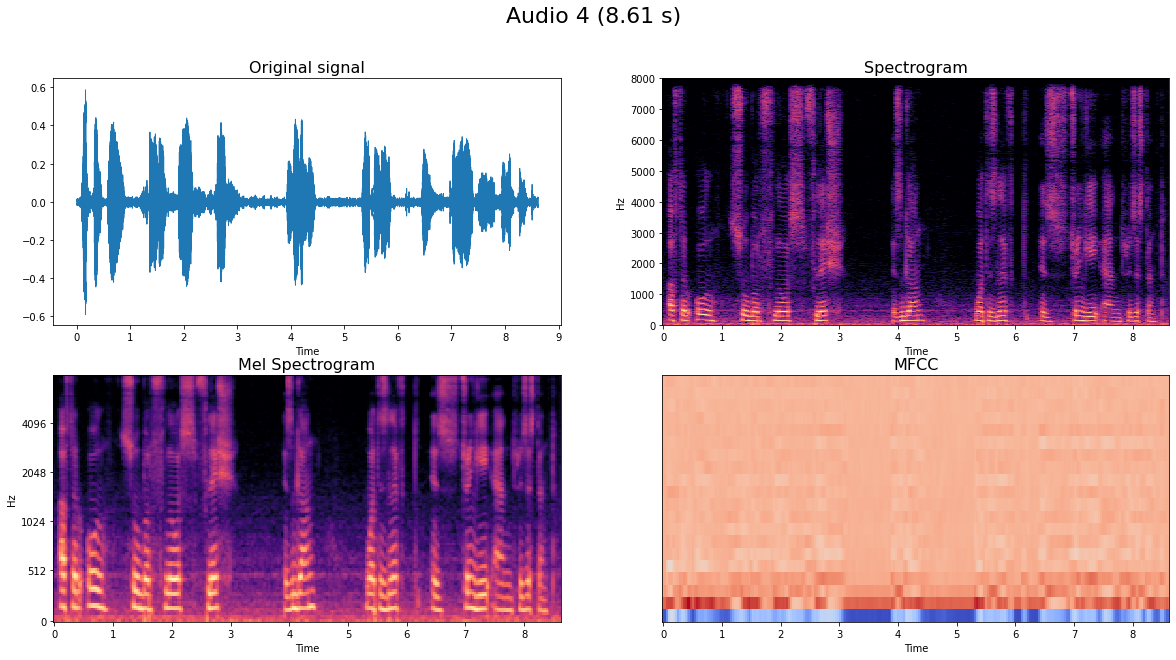

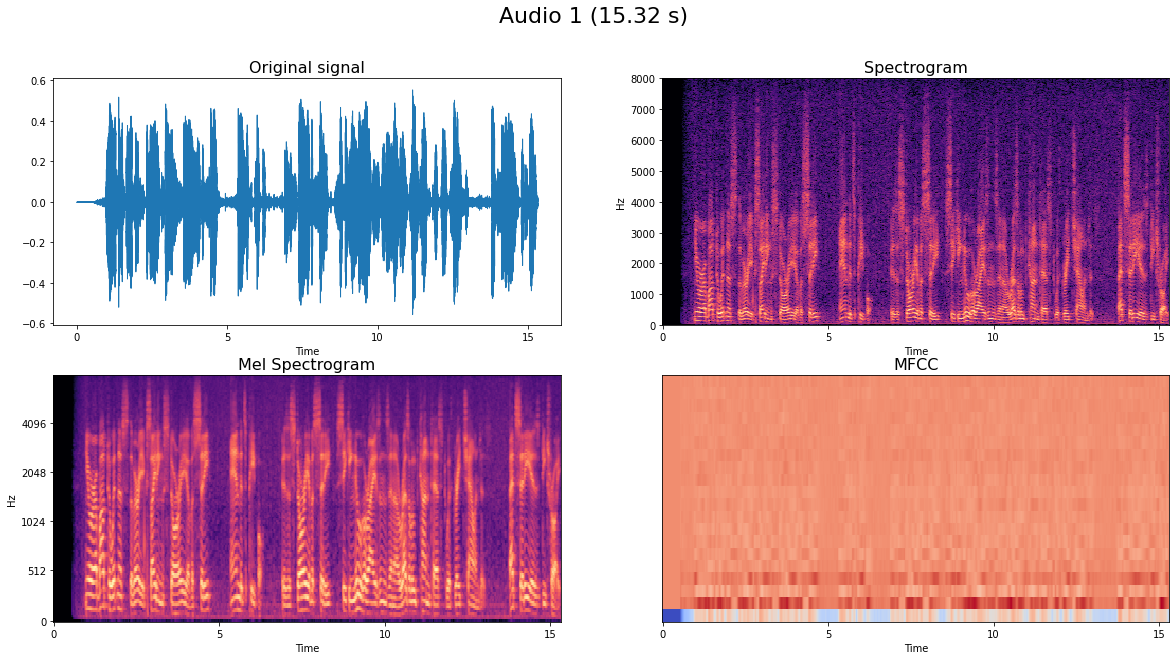

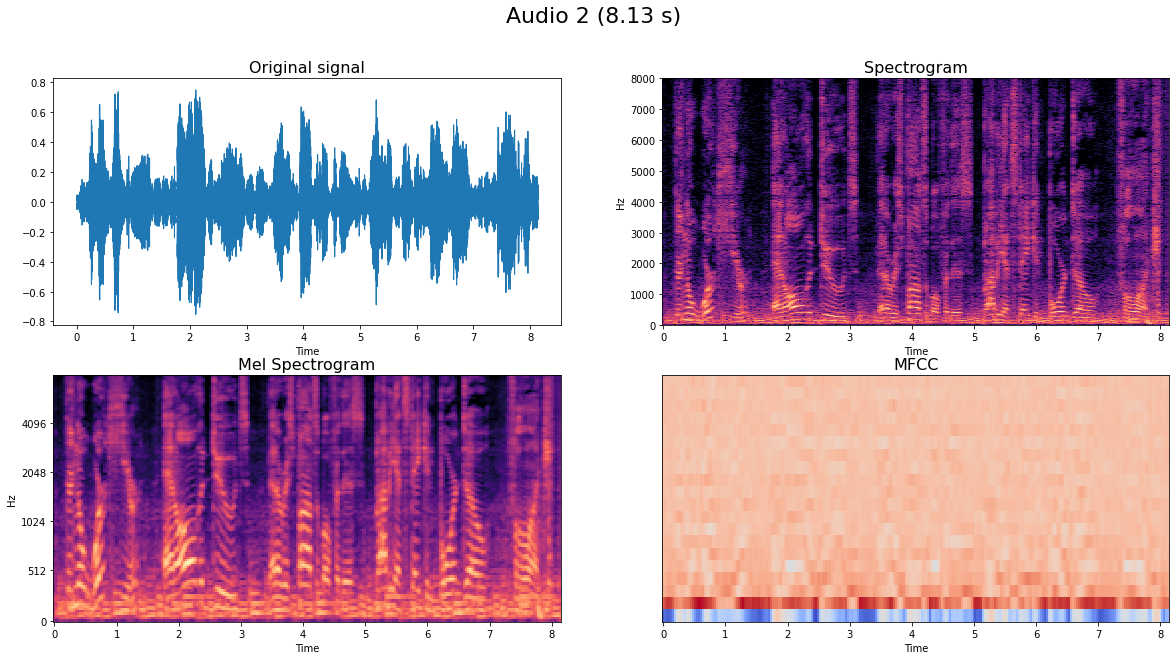

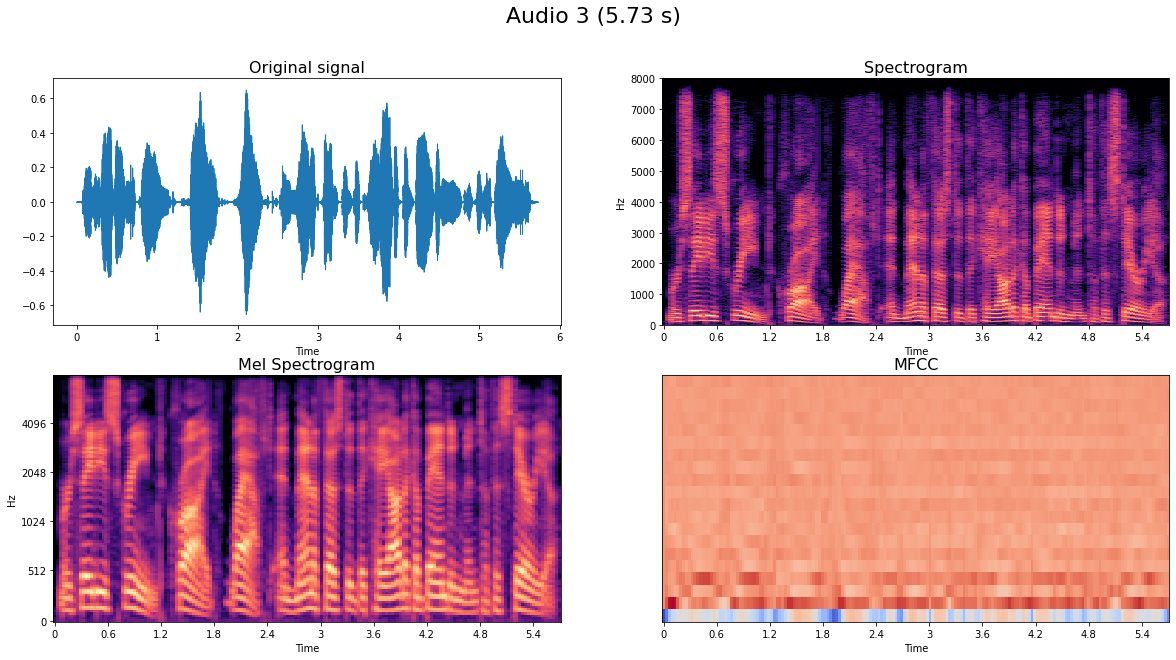

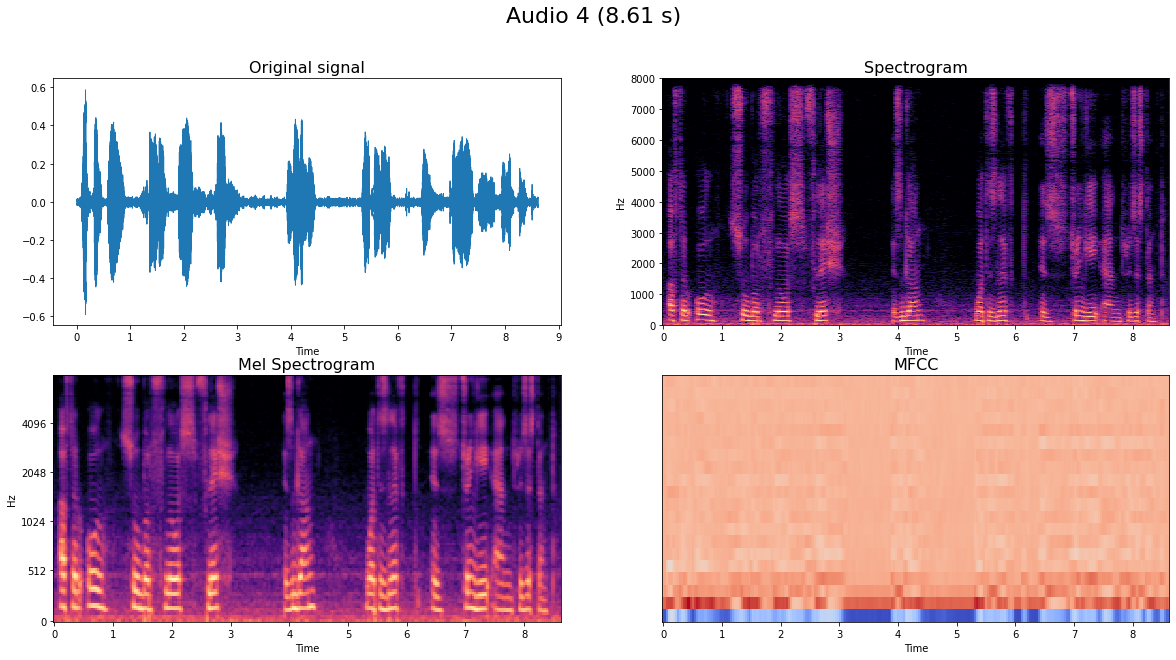

In [21]:
for i in range(files_num):
  file = f"{SPEECH_AUDIO_PATH}{i+1}.wav"
  show_audio_diagrams(file)

## Применяем аугментацию и выводим спектрограммы

In [9]:
def audio_augmentation(file_path, level=0):
  signal = read_audio(file_path)
  augmented_signal = signal.unsqueeze(0)

  noise = AddNoise(snr_low=5, snr_high=20)
  augmented_signal = noise(augmented_signal, torch.ones(1))#
  
  if level > 0:
    perturbator = SpeedPerturb(orig_freq=SAMPLE_RATE, speeds=[120])
    augmented_signal = perturbator(augmented_signal)

  if level > 1:
    drop = DropFreq(drop_freq_low=0.0005, drop_freq_high=0.008, drop_width=0.1)
    augmented_signal = drop(augmented_signal)

  fig, ax = plt.subplots(1, 2)
  plt.rcParams['figure.figsize'] = (20, 4)

  plt.suptitle(f'Augmented audio {i+1}', size=22)

  # выводим сигнал
  librosa.display.waveshow(augmented_signal.squeeze().numpy(), sr=SAMPLE_RATE, ax=ax[0])
  ax[0].title.set_text('Original signal')

  # выводим спектрограмму
  spectre = librosa.amplitude_to_db(np.abs(librosa.stft(augmented_signal.squeeze().numpy())), ref=np.max)
  librosa.display.specshow(spectre, y_axis='linear', x_axis='time', sr=SAMPLE_RATE, ax=ax[1])
  ax[1].title.set_text('Spectrogram')

  plt.show()

  # прослушивание аудио
  display(Audio(augmented_signal, rate=SAMPLE_RATE))

  return augmented_signal

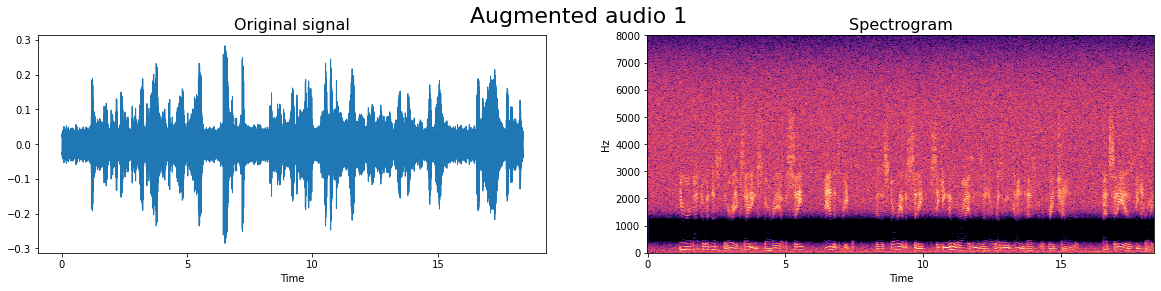

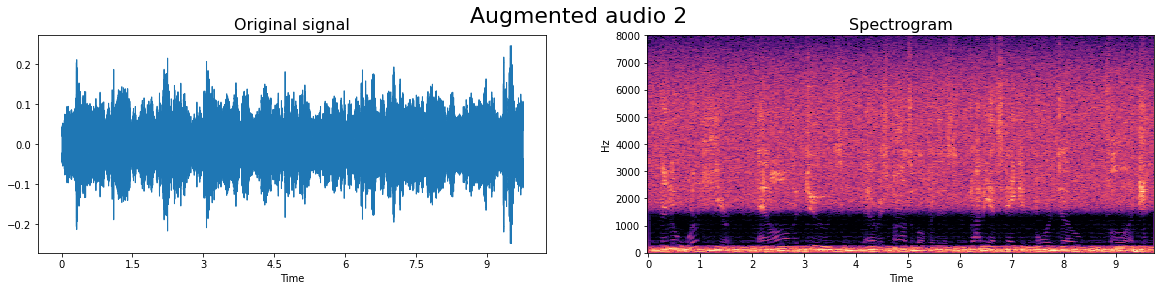

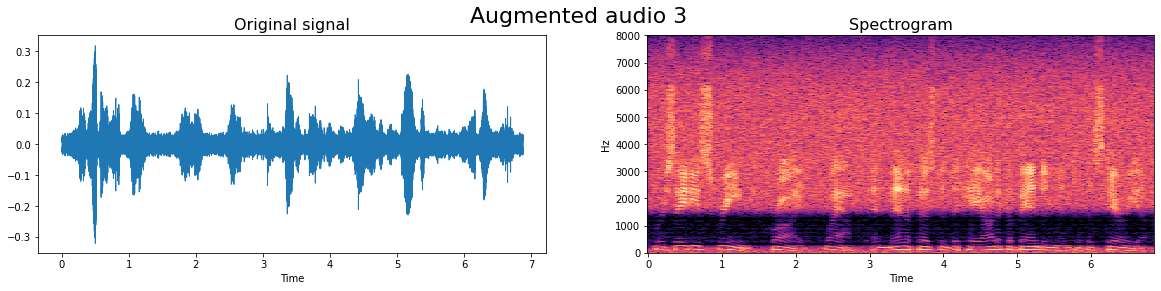

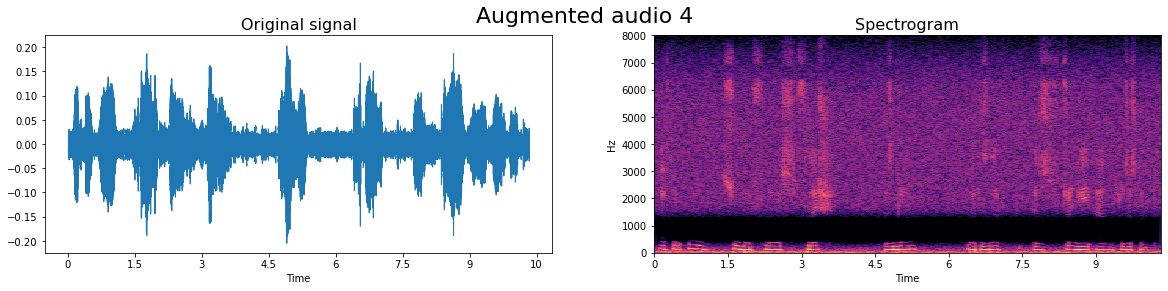

In [23]:
for i in range(files_num):
  file = f"{SPEECH_AUDIO_PATH}{i+1}.wav"
  augmented = audio_augmentation(file, 2)

  soundfile.write(f"{SPEECH_AUGMENTED_PATH}{i+1}.wav", np.ravel(augmented.numpy()), SAMPLE_RATE)

## Строим пайплайн распознавания речи

## Загрузим модели NeMo

Модель **NeMo QuartzNet**

In [11]:
model_quartz = nemo_asr.models.EncDecCTCModel.from_pretrained(model_name="QuartzNet15x5Base-En")

[NeMo I 2023-03-05 10:11:59 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.15.0/QuartzNet15x5Base-En/2b066be39e9294d7100fb176ec817722/QuartzNet15x5Base-En.nemo.
[NeMo I 2023-03-05 10:11:59 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.15.0/QuartzNet15x5Base-En/2b066be39e9294d7100fb176ec817722/QuartzNet15x5Base-En.nemo
[NeMo I 2023-03-05 10:11:59 common:913] Instantiating model from pre-trained checkpoint
[NeMo I 2023-03-05 10:12:01 features:267] PADDING: 16


ERROR:numba.cuda.cudadrv.driver:Call to cuInit results in CUDA_ERROR_NO_DEVICE


[NeMo I 2023-03-05 10:12:02 save_restore_connector:243] Model EncDecCTCModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.15.0/QuartzNet15x5Base-En/2b066be39e9294d7100fb176ec817722/QuartzNet15x5Base-En.nemo.


Модель **NeMo stt_en_conformer_transducer_large**

In [12]:
model_conformer = nemo_asr.models.EncDecRNNTBPEModel.from_pretrained(model_name="stt_en_conformer_transducer_large")

[NeMo I 2023-03-05 10:12:02 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.15.0/stt_en_conformer_transducer_large/1919c44e1281bbcba59356c6091a6b94/stt_en_conformer_transducer_large.nemo.
[NeMo I 2023-03-05 10:12:02 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.15.0/stt_en_conformer_transducer_large/1919c44e1281bbcba59356c6091a6b94/stt_en_conformer_transducer_large.nemo
[NeMo I 2023-03-05 10:12:02 common:913] Instantiating model from pre-trained checkpoint
[NeMo I 2023-03-05 10:12:06 mixins:170] Tokenizer SentencePieceTokenizer initialized with 1024 tokens


[NeMo W 2023-03-05 10:12:08 modelPT:156] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath:
    - - /data/NeMo_ASR_SET/English/v3.0/train_bucketed/bucket1/tarred_audio_manifest.json
    - - /data/NeMo_ASR_SET/English/v3.0/train_bucketed/bucket2/tarred_audio_manifest.json
    - - /data/NeMo_ASR_SET/English/v3.0/train_bucketed/bucket3/tarred_audio_manifest.json
    - - /data/NeMo_ASR_SET/English/v3.0/train_bucketed/bucket4/tarred_audio_manifest.json
    - - /data/NeMo_ASR_SET/English/v3.0/train_bucketed/bucket5/tarred_audio_manifest.json
    - - /data/NeMo_ASR_SET/English/v3.0/train_bucketed/bucket6/tarred_audio_manifest.json
    - - /data/NeMo_ASR_SET/English/v3.0/train_bucketed/bucket7/tarred_audio_manifest.json
    - - /data/NeMo_ASR_SET/English/v3.0/train_bucketed/bucket8/tarred_audio_manifest.json
    sample_rate: 16000
    

[NeMo I 2023-03-05 10:12:08 features:267] PADDING: 0


[NeMo W 2023-03-05 10:12:11 nemo_logging:349] /usr/local/lib/python3.8/dist-packages/torch/nn/modules/rnn.py:67: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
      warnings.warn("dropout option adds dropout after all but last "
    


[NeMo I 2023-03-05 10:12:12 rnnt_models:207] Using RNNT Loss : warprnnt_numba
    Loss warprnnt_numba_kwargs: {'fastemit_lambda': 0.0, 'clamp': -1.0}
[NeMo I 2023-03-05 10:12:13 save_restore_connector:243] Model EncDecRNNTBPEModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.15.0/stt_en_conformer_transducer_large/1919c44e1281bbcba59356c6091a6b94/stt_en_conformer_transducer_large.nemo.


In [13]:
NEMO_BATCH_SIZE = 16

Формируем списки текстов и аудио-файлов

In [14]:
references = []
audio_files = []
augmented_files = []

for i in range(files_num):
  # читаем текстовые файлы
  sample_text_file = f"{SPEECH_TEXT_PATH}{i+1}.txt"
  tf = open(sample_text_file)
  references.append(tf.read())
  tf.close()

  # формируем список файлов
  audio_files.append(f"{SPEECH_AUDIO_PATH}{i+1}.wav")
  augmented_files.append(f"{SPEECH_AUGMENTED_PATH}{i+1}.wav")
  
references = np.array(references)

## Функция распознавания и подсчета метрики WER

In [15]:
def asr_model(model, files, references, verbose=False):
  predictions = model.transcribe(
    paths2audio_files=files,
    batch_size=NEMO_BATCH_SIZE
  )

  if (type(predictions) == tuple):
    predictions = list(predictions)[0]

  predictions = np.array(predictions)
  wer = word_error_rate(predictions, references)

  if verbose:
    print('Text:')
    print(references)
    print()
    print('Predictions:')
    print(predictions)
    print()
    print(f"WER: {round(wer, 4)}")

  return predictions, wer

## Распознаем речь в аудио-файлах

Применим модель **NeMo QuartzNet**

Выведем метрику для исходных аудио-файлов

In [16]:
predictions, wer = asr_model(model_quartz, audio_files, references, verbose=True)

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Text:
['you are about to witness the very exciting story of a city and its people it is a story of a city seeking new horizons in a resolute contest with great challenges that city is detroit'
 "there's no work here and all the dudes that are responsible for this probably had steak and bordeaux for lunch"
 'mercedes screamed cried laughed and manifested the chaotic abandonment of hysteria'
 'after all superfluous flesh is gone what is left is stringy and resistant']

Predictions:
['you are about to witness the very exciting story of a city and its people it is a story of a city seeking new horizons in a resolute contest with great challenges that city is detroit'
 "there's no work here and all the dudes that are responsible for this probably had staken boardough flunch"
 'mercedes screamed cried laughed and manifested the chaotic abandonment of hysteria'
 'after all sober floos flesh is gone what is left is stringy and resistant']

WER: 0.0875


Выведем метрику для аугментированных аудио-файлов

In [17]:
predictions, wer = asr_model(model_quartz, augmented_files, references, verbose=True)

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Text:
['you are about to witness the very exciting story of a city and its people it is a story of a city seeking new horizons in a resolute contest with great challenges that city is detroit'
 "there's no work here and all the dudes that are responsible for this probably had steak and bordeaux for lunch"
 'mercedes screamed cried laughed and manifested the chaotic abandonment of hysteria'
 'after all superfluous flesh is gone what is left is stringy and resistant']

Predictions:
['you were about to witness the very exciting story of a city and its people it is estory in a city seeking new horizons in a resolute contest with great challenges that city is detroyt'
 'wooher dal on te junes that are responsible for this sabe had taken bor doforar'
 'mercede screem cried laughed and manipested the chaotic abandonment of hysteria'
 'after all she was mose lish isgun what is lit is tringy and psistan']

WER: 0.375


Применим модель **NeMo stt_en_conformer_transducer_large**

Выведем метрику для исходных аудио-файлов

In [18]:
predictions, wer = asr_model(model_conformer, audio_files, references, verbose=True)

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Text:
['you are about to witness the very exciting story of a city and its people it is a story of a city seeking new horizons in a resolute contest with great challenges that city is detroit'
 "there's no work here and all the dudes that are responsible for this probably had steak and bordeaux for lunch"
 'mercedes screamed cried laughed and manifested the chaotic abandonment of hysteria'
 'after all superfluous flesh is gone what is left is stringy and resistant']

Predictions:
['are about to witness the very exciting story of a city and its people it is a story of a city seeking new horizons in a resolute contest with great challenges that city is detroit'
 "there's no work here and all the dudes that are responsible for this probably at stake in bordeaux for lunch"
 'mercedes screamed cried laughed and manifested the chaotic abandonment of hysteria'
 'after all superfluous flesh is gone what is left is stringy and resistant']

WER: 0.05


Выведем метрику для аугментированных аудио-файлов

In [19]:
predictions, wer = asr_model(model_conformer, augmented_files, references, verbose=True)

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Text:
['you are about to witness the very exciting story of a city and its people it is a story of a city seeking new horizons in a resolute contest with great challenges that city is detroit'
 "there's no work here and all the dudes that are responsible for this probably had steak and bordeaux for lunch"
 'mercedes screamed cried laughed and manifested the chaotic abandonment of hysteria'
 'after all superfluous flesh is gone what is left is stringy and resistant']

Predictions:
['you are about to witness the very exciting story of a city of a city seeking new rises in a resolute contest with that city detroit'
 'responsible for this bobby at stake in'
 'mercedes scream cried laugh and manifested the chaotic abandonment hysteria'
 'after all sorbet flows flesh is gone what is left is stringy and resistant']

WER: 0.4125
